In [1]:
import datetime

date = datetime.datetime.now()
print(f'Today is Happy{date: %A, %d, %m, %Y}.', '\n')

import os
from glob import glob
import math
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
import scipy as sp
from scipy import stats
from scipy.stats import norm, wilcoxon, linregress 
import scipy.stats as sp
from statannot import add_stat_annotation
import cv2 as cv
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append('../code')
from dataloader.kface16000 import KFaceDataLoader
from models import PPO, Policy, AC, DQN, CNN

sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   
sns.set_style('whitegrid', rc={'font.family': 'serif', 'font.serif': 'Times New Roman'})

Today is Happy Monday, 07, 11, 2022. 



c:\ProgramData\Anaconda3\envs\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Button

In [142]:
date = '2022-11-07'
time = '14-59-04'
windows = True # True for Windows, False for MAC
train = 'RL' # 'RL' or 'SL
stim_type = 'opt' # 'opt' or 'elec'
top1 = False # True for top1, False if top2
class_num = 16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if windows:
    base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Project\\code'
    slash = '\\'
else:
    base_dir = '/Users/naminan/Development/Project/c ode'
    slash = '/'

data_dir = os.path.join(base_dir, 'data')
data_path = os.path.join(data_dir, '210827_ANNA_Removing_uncontaminated_data.csv')
label_path = os.path.join(data_dir, '211105_QAs_for_Set0_CNN_SVC_4classes_partial.csv')
pred_dir =  os.path.join(os.path.join(data_dir, 'Human_Expert'), '211202')

df = pd.read_csv(data_path)
l = list(range(df.shape[0]))
random.seed(22)
set_1 = random.sample(l, class_num)
face_lst = [df.iloc[i, 0] for i in set_1]
face_dic_r = {int(i) : str(face) for (i, face) in enumerate(face_lst)}

if stim_type == 'opt':
        image_dir = f'{data_dir}{slash}sample_for_dev_test'
elif stim_type == 'elec':
    image_dir = f'{data_dir}{slash}sample_for_dev_test2'

if train == 'RL':
    env_type = 'Bioniceye' #'CartPole-v1'
    model_type = 'DQN' # 'PPO' or 'REINFORCE' or 'AC' or 'DQN'
    learning_rate, gamma, lmbda, eps_clip, batch_size = None, None, None, None, None
    outputs_dir = os.path.join(base_dir, 'outputs') # {slash}date{slash}time{slash}outputs

    model_state_dict_files = glob(f'{outputs_dir}{slash}{date}{slash}{time}{slash}outputs{slash}{env_type}_{model_type}.pth', recursive=True)
    train_returns_files = glob(f'{outputs_dir}{slash}{date}{slash}{time}{slash}outputs{slash}TrainReturns_{env_type}_{model_type}.csv', recursive=True)
    correctness_files = glob(f'{outputs_dir}{slash}{date}{slash}{time}{slash}outputs{slash}Correctness_{env_type}_{model_type}.csv', recursive=True)
    model_state_dict_files = list(set(model_state_dict_files))
    model_state_dict_files.sort()
    train_returns_files.sort()
    correctness_files.sort()
    assert len(model_state_dict_files) != 0
    #assert len(train_returns_files) != 0
    assert len(correctness_files) != 0

elif train == 'SL':
    multirun_dir = os.path.join(base_dir, 'multirun')
    model_state_dict_files = glob(f'{multirun_dir}{slash}{date}{slash}**{slash}**{slash}outputs{slash}CNN.pth', recursive=True)
    model_state_dict_files = list(set(model_state_dict_files))
    model_state_dict_files.sort()
    assert len(model_state_dict_files) != 0

### Human data

In [3]:
if stim_type == 'opt':
  sel_ppl = list(range(300, 309)) + list(range(400, 408)) + [611] # 18 subjects
elif stim_type == 'elec': 
  # sel_ppl = [499, 500, 502] + list(range(504, 509)) + list(range(602, 606)) + list(range(608, 612)) # 16 subjects (no min & max)
  sel_ppl = [499, 500, 502] + list(range(503, 509)) + list(range(602, 607)) + list(range(608, 612)) # 18 subjects

human_df = pd.DataFrame()
preds = []
n = 9
for i in range(1, 80*n+1, 80):
    j = i+79 
    temp_df = pd.read_csv(os.path.join(pred_dir, f'main_test({i}_{j}).csv'))
    temp_df = temp_df[temp_df['유저식별아이디'].isin(sel_ppl)]
    human_df = pd.concat([human_df, temp_df], axis=1)
    # To calculate the mode
    if top1:
      temp_df = temp_df.loc[:, temp_df.columns.str.startswith('선택_A')]
      temp_df = temp_df.fillna(0)
      for k in range(len(temp_df.columns)):
          temp_preds = temp_df.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds = temp_preds[temp_preds > 0]
          temp_pred = np.bincount(temp_preds).argmax() 
          preds.append(temp_pred)
    else:
      temp_df1 = temp_df.loc[:, temp_df.columns.str.startswith('선택_A')]
      temp_df2 = temp_df.loc[:, temp_df.columns.str.startswith('선택_B')]
      temp_df1, temp_df2 = temp_df1.fillna(0), temp_df2.fillna(0)
      for k in range(len(temp_df1.columns)):
          temp_preds1 = temp_df1.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds2 = temp_df2.iloc[:, k].values.astype(str).astype(float).astype(int)
          temp_preds = np.concatenate([temp_preds1, temp_preds2])
          temp_preds = temp_preds[temp_preds > 0]
          temp_pred = np.bincount(temp_preds).argmax() 
          preds.append(temp_pred)  
        
orig_human_df = human_df
human_df = human_df.fillna(0)

sel_col = []
for j in range(1, 80*n+1):
  if top1:
    temp_str = f'선택_A_{j}'
    sel_col.append(temp_str)
  else:
    temp_str1 = f'선택_A_{j}'
    temp_str2 = f'선택_B_{j}'
    sel_col.append(temp_str1)
    sel_col.append(temp_str2)

human_df = human_df[sel_col]
human_df.index = sel_ppl 

if top1:
  human_df.columns = list(range(80*n))
else:
  human_df.columns = list(range(2*80*n))

question_df = pd.read_csv(label_path)

if top1:
  human_df.columns = question_df['Answer']
else:
  human_df.columns = [ans for ans in question_df['Answer'] for _ in (0, 1)]

processed_human_df = human_df.copy()
for (j, ans_file) in enumerate(processed_human_df.columns):
    face, pix, gs, par = ans_file.split('.')[0].split('_')
    act_face = int(face)
    for i in range(processed_human_df.shape[0]):
        pred_face = int(processed_human_df.iloc[i, j])
        if act_face == pred_face:
            processed_human_df.iloc[i, j] = 1.0
        else:
            processed_human_df.iloc[i, j] = 0.0

if not top1:
  processed_human_df = processed_human_df.iloc[:, 0:1440:2] + processed_human_df.iloc[:, 1:1440:2]

processed_human_df_T = processed_human_df.transpose()
face_lst, pix_lst, gs_lst, par_lst, exp_lst = [], [], [], [], []
for (i, ans_file) in enumerate(processed_human_df_T.index):
  face, pix, gs, par = ans_file.split('.')[0].split('_')
  face_lst.append(face)
  pix_lst.append(pix)
  gs_lst.append(gs)
  par_lst.append(par)
  exp_lst.append(par.split('C')[0].split('E')[-1])
processed_human_df_T['Face'] = face_lst
processed_human_df_T['PIX'] = pix_lst
processed_human_df_T['GS'] = gs_lst
processed_human_df_T['Par'] = par_lst
processed_human_df_T['Exp'] = exp_lst
processed_human_df_T['Mean'] = processed_human_df_T[sel_ppl].mean(axis=1)
processed_human_df_T['Mode'] = preds
temp_lst = list(map(int, (processed_human_df_T['Mode'].astype(int) == processed_human_df_T['Face'].astype(int)).tolist()))
processed_human_df_T['Mode'] = temp_lst


setorder_lst = [n for n in range(9)]*80
setorder_lst.sort()
processed_human_df_T['Set'] = setorder_lst

imp_par_lst = []
for i in range(processed_human_df_T.shape[0]):
  pix = processed_human_df_T['PIX'][i]
  gs = processed_human_df_T['GS'][i]
  exp = processed_human_df_T['Exp'][i]
  imp_par = f'{pix}_{gs}'#_{exp}' # {gs}
  imp_par_lst.append(imp_par)
processed_human_df_T['ImpPar'] = imp_par_lst

processed_human_df_T = processed_human_df_T.reset_index()
processed_human_df_T['Set'] = [idx//80+1 for idx in processed_human_df_T.index]

processed_human_df_T

,index,300,301,302,303,304,305,306,307,308,...,611,Face,PIX,GS,Par,Exp,Mean,Mode,Set,ImpPar
0,19070311_16PIX_8GS_S001L1E03C7.jpg,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,19070311,16PIX,8GS,S001L1E03C7,03,0.444444,1,1,16PIX_8GS
1,19080133_32PIX_4GS_S001L1E03C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,19080133,32PIX,4GS,S001L1E03C7,03,0.777778,1,1,32PIX_4GS
2,19090222_32PIX_8GS_S001L1E01C4.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,19090222,32PIX,8GS,S001L1E01C4,01,0.444444,1,1,32PIX_8GS
3,19090631_16PIX_2GS_S001L1E03C7.jpg,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,19090631,16PIX,2GS,S001L1E03C7,03,0.555556,1,1,16PIX_2GS
4,19072221_32PIX_2GS_S001L1E01C4.jpg,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,19072221,32PIX,2GS,S001L1E01C4,01,0.722222,1,1,32PIX_2GS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,19072221_16PIX_8GS_S001L1E01C7.jpg,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,19072221,16PIX,8GS,S001L1E01C7,01,0.777778,1,9,16PIX_8GS
716,19082131_16PIX_2GS_S001L1E01C7.jpg,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,19082131,16PIX,2GS,S001L1E01C7,01,0.444444,0,9,16PIX_2GS
717,19092521_32PIX_4GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,19092521,32PIX,4GS,S001L1E01C7,01,1.000000,1,9,32PIX_4GS
718,19081632_64PIX_2GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,19081632,64PIX,2GS,S001L1E01C7,01,0.888889,1,9,64PIX_2GS


### Model Results

In [143]:
hum_mod_df = processed_human_df_T.copy()

if train == 'RL':
    for i in range(len(correctness_files)):
        temp_df = pd.DataFrame()
        correctness_df = pd.read_csv(correctness_files[i], index_col=0)
        correctness_df = correctness_df.dropna(axis=1, how='all')
        ins_num = correctness_df.shape[-1] // 9
        ques_num = correctness_df.shape[0] // 9
        assert ques_num == 80
        p = 0 
        for j in range(0, correctness_df.shape[0], ques_num):
            if j == 0:
                temp_df = correctness_df[[str(n) for n in range(p, p+ins_num)]].iloc[j:j+ques_num, :]
                temp_df.columns = range(ins_num)
            else:
                correctness_temp_df = correctness_df[[str(n) for n in range(p, p+ins_num)]].iloc[j:j+ques_num, :]
                correctness_temp_df.columns = range(ins_num)
                temp_df = pd.concat([temp_df, correctness_temp_df], axis=0, ignore_index=True)
            p += ins_num
    temp_df.columns = [f'M{i}' for i in range(1, ins_num+1)]
    sel_mod = [f'M{i}' for i in range(1, ins_num+1)]
    hum_mod_df[sel_mod] = temp_df
elif train == 'SL':
    for i in range(len(model_state_dict_files)):
        KFaceDataset = KFaceDataLoader(image_dir, data_path, label_path, class_num, 'test', None)
        test_loader = DataLoader(KFaceDataset, batch_size=1, shuffle=False)

        model = CNN(class_num).to(device)
        model.load_state_dict(torch.load(model_state_dict_files[i]))

        temp_lst = []
        model.eval()
        with torch.no_grad():
            for (image, label) in test_loader:
                image, label = image.to(device), label.to(device)
                if train == 'RL':
                    image = torch.unsqueeze(image, 0)
                    if model_type == 'PPO' or model_type == 'REINFORCE' or model_type == 'AC':
                        pred_probs = model.forward_pi(image.float())
                    elif model_type == 'DQN':
                        pred_probs = model(image.float())
                elif train == 'SL':
                    pred_probs = model(image)
                _, pred_label = torch.max(pred_probs, dim=-1)

                if int(pred_label) == int(label):
                    temp_lst.append(1.0)
                else:
                    temp_lst.append(0.0)

        hum_mod_df[f'M{i+1}'] = temp_lst

    sel_mod = [f'M{i}' for i in range(1, len(model_state_dict_files)+1)]
    hum_mod_df['Mean_SL'] = hum_mod_df[sel_mod].mean(axis=1) 

hum_mod_df

,index,300,301,302,303,304,305,306,307,308,...,M9,M10,M11,M12,M13,M14,M15,M16,M17,M18
0,19070311_16PIX_8GS_S001L1E03C7.jpg,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19080133_32PIX_4GS_S001L1E03C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,19090222_32PIX_8GS_S001L1E01C4.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19090631_16PIX_2GS_S001L1E03C7.jpg,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19072221_32PIX_2GS_S001L1E01C4.jpg,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,19072221_16PIX_8GS_S001L1E01C7.jpg,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
716,19082131_16PIX_2GS_S001L1E01C7.jpg,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717,19092521_32PIX_4GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
718,19081632_64PIX_2GS_S001L1E01C7.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Graphs

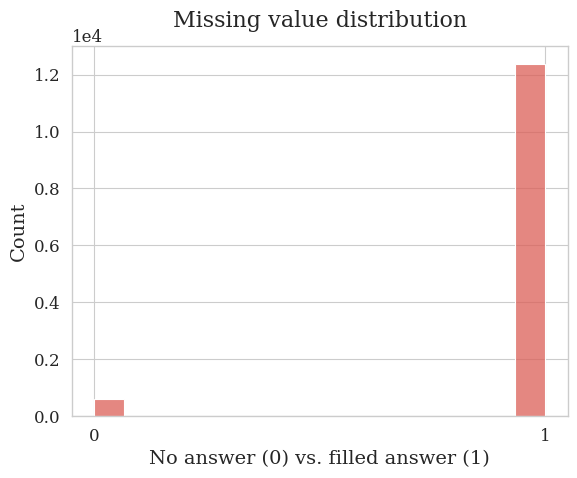

In [19]:
# Check nan values (x-axis: ID #, 0 means there was no answer)
bin_arr = np.where(human_df.values > 0.0, 1.0, 0.0).flatten()
sns.histplot(bin_arr, color=sns.color_palette('hls', 8)[0])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 4))
plt.xticks(range(0, 2))
plt.xlabel('No answer (0) vs. filled answer (1)')
plt.title('Missing value distribution', y=1.03)
plt.show()

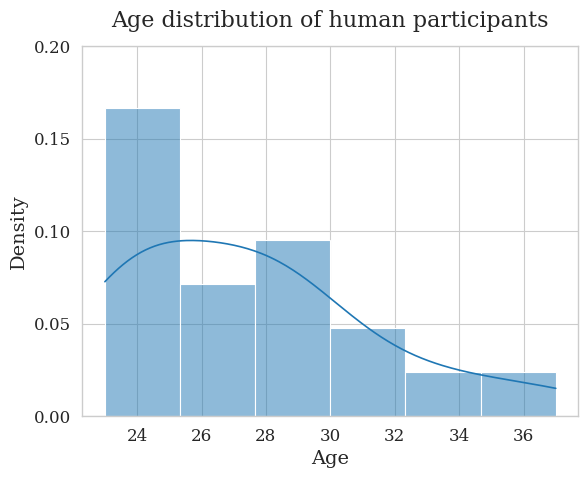

In [20]:
# Check age density 
sns.histplot(data=orig_human_df['나이'], stat='density', kde=True)
plt.yticks(np.arange(0.0, 0.21, 0.05))
plt.xlabel('Age')
plt.title('Age distribution of human participants', y=1.03)
plt.show()

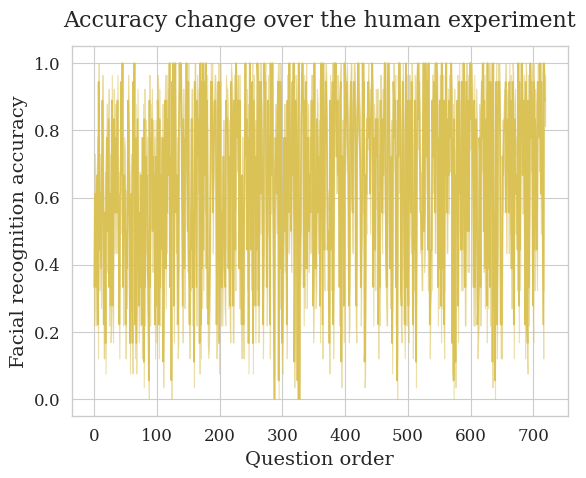

In [4]:
# Draw accuracy values per set order
x = range(processed_human_df.shape[-1])
y_mean, y_stderr = processed_human_df.mean(axis=0), processed_human_df.std(axis=0) / math.sqrt(processed_human_df.shape[0])
sns.lineplot(x=x, y=y_mean, color=sns.color_palette('hls', 8)[1])
plt.fill_between(x=x, y1=y_mean - y_stderr, y2=y_mean + y_stderr, color=sns.color_palette('hls', 8)[1], alpha=0.5)
plt.xlabel('Question order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1.03)
plt.show()

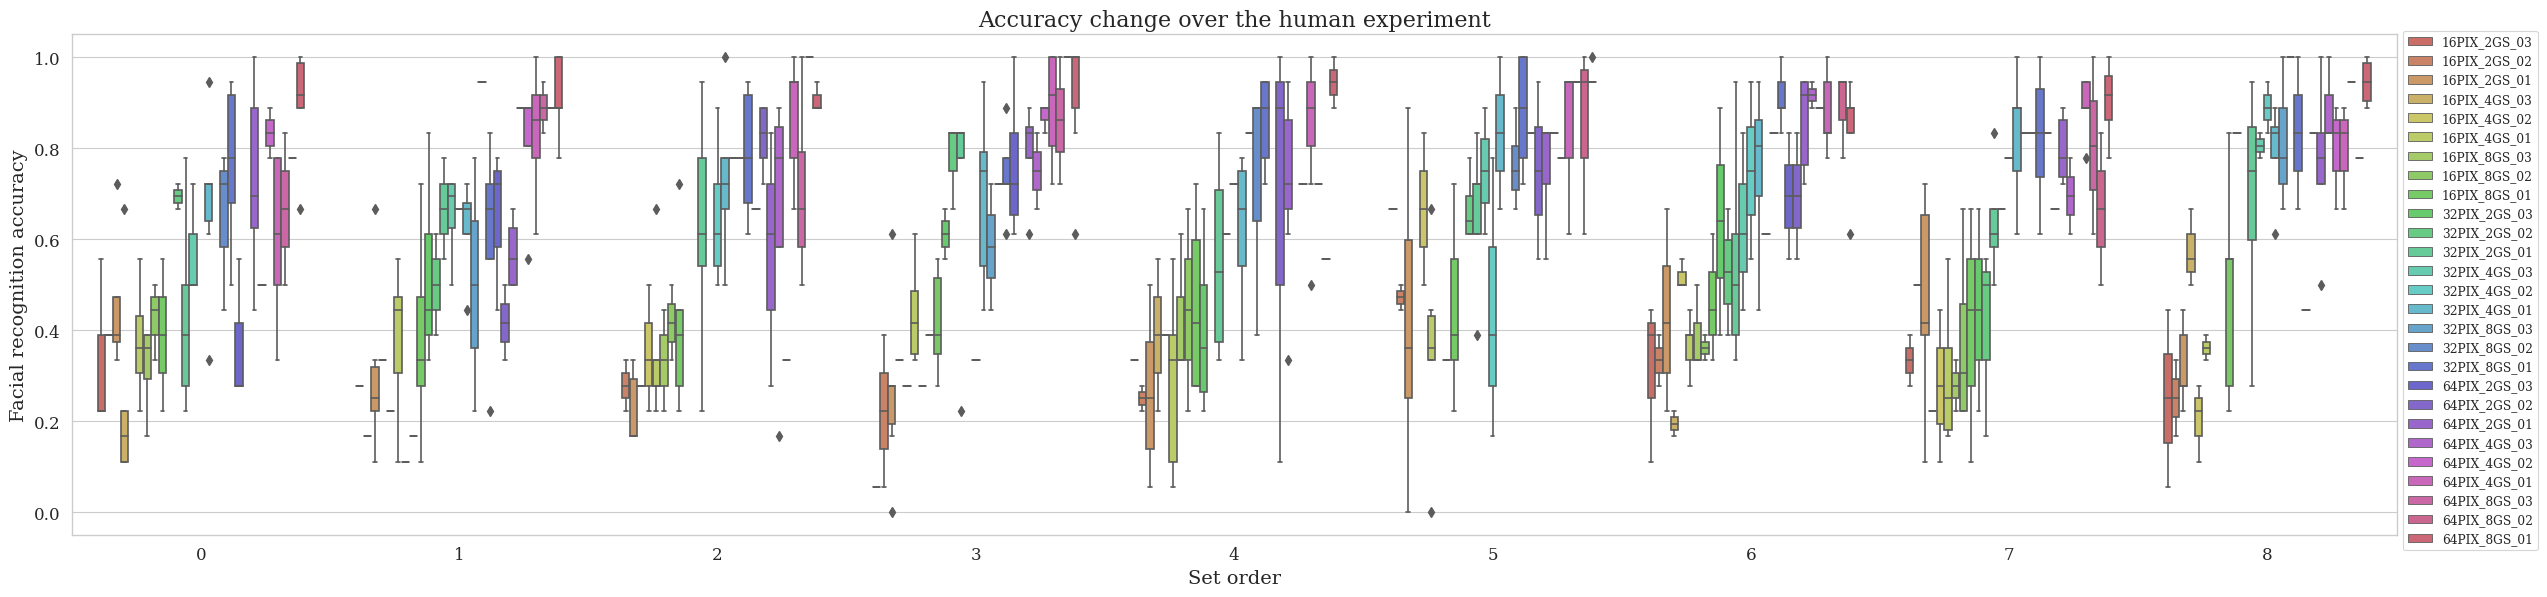

In [151]:
# Draw accuracy values per set order (with hues)
hue_order = ['16PIX_2GS_03', '16PIX_2GS_02', '16PIX_2GS_01',
             '16PIX_4GS_03', '16PIX_4GS_02', '16PIX_4GS_01',
             '16PIX_8GS_03', '16PIX_8GS_02', '16PIX_8GS_01',
             '32PIX_2GS_03', '32PIX_2GS_02', '32PIX_2GS_01',
             '32PIX_4GS_03', '32PIX_4GS_02', '32PIX_4GS_01',
             '32PIX_8GS_03', '32PIX_8GS_02', '32PIX_8GS_01',
             '64PIX_2GS_03', '64PIX_2GS_02', '64PIX_2GS_01',
             '64PIX_4GS_03', '64PIX_4GS_02', '64PIX_4GS_01',
             '64PIX_8GS_03', '64PIX_8GS_02', '64PIX_8GS_01']

plt.figure(figsize=(30, 6.5))
sns.boxplot(x='Set', y='Mean', hue='ImpPar', data=processed_human_df_T, palette=sns.color_palette("hls", 27),
            hue_order=hue_order)
plt.xlabel('Set order')
plt.ylabel('Facial recognition accuracy')
plt.title('Accuracy change over the human experiment', y=1)
plt.legend(bbox_to_anchor=(1, 1.02))
plt.show()

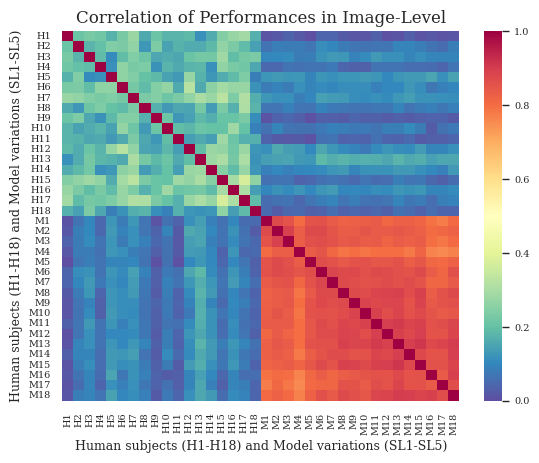

In [144]:
sel_df = hum_mod_df[sel_ppl + sel_mod]
sel_df = sel_df.astype(float)
corr = sel_df.corr()
corr.index = [f'H{i}' for i in range(1, len(sel_ppl)+1)] + sel_mod
corr.columns = [f'H{i}' for i in range(1, len(sel_ppl)+1)] + sel_mod

sns.set_context("paper", rc={"axes.titlesize":12,"axes.labelsize":9, "xtick.labelsize":7, "ytick.labelsize":7})   

sns.heatmap(corr, vmin=0.0, vmax=1.0, cmap=sns.color_palette('Spectral_r', as_cmap=True))
plt.title('Correlation of Performances in Image-Level')
plt.xlabel('Human subjects (H1-H18) and Model variations (SL1-SL5)')
plt.ylabel('Human subjects (H1-H18) and Model variations (SL1-SL5)')
plt.show()

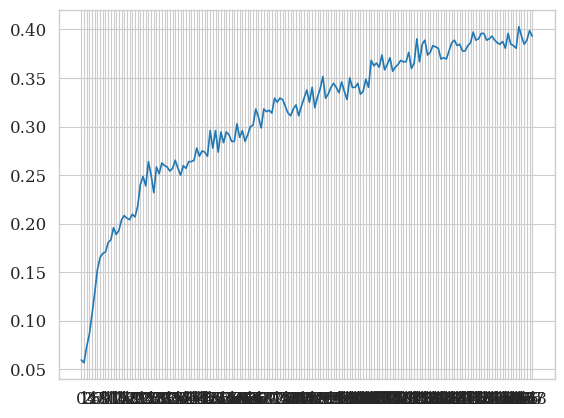

In [147]:
# Draw coorectness
sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   

plt.plot(correctness_df.mean(axis=0))
plt.show()

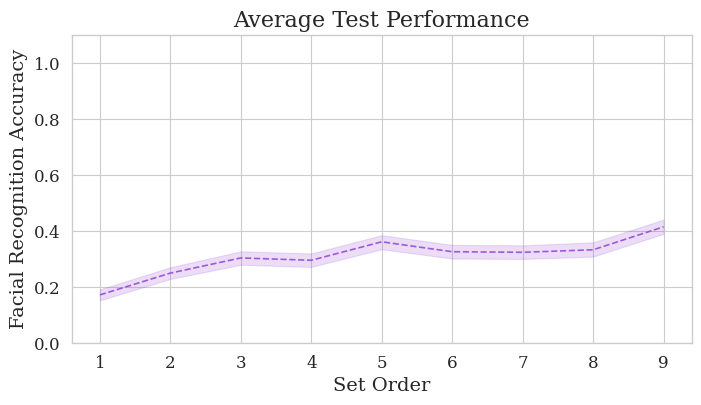

In [148]:
# Draw average test performance over trials
sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12})   

hum_mod_df_temp = hum_mod_df.copy()
hum_mod_df_temp.index = hum_mod_df['Set']
hum_mod_df_temp = hum_mod_df_temp[sel_mod].stack().reset_index() # sel_ppl or sel_mod
hum_mod_df_temp.columns = ['Set', 'Model', 'Mean']
plt.figure(figsize=(8, 4))
sns.lineplot(x='Set', y='Mean', data=hum_mod_df_temp, color=sns.color_palette('hls', len(pix_lst)+1)[3], linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('Set Order')
plt.ylabel('Facial Recognition Accuracy')
plt.title(f'Average Test Performance')
plt.show()

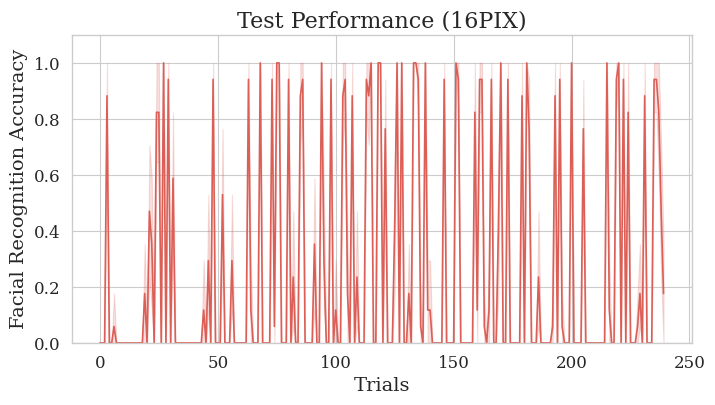

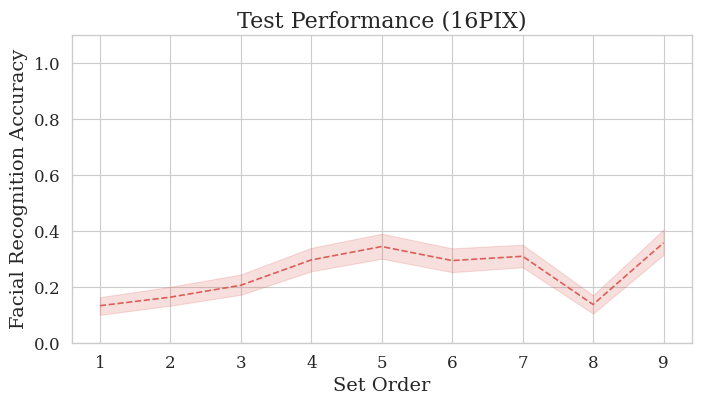

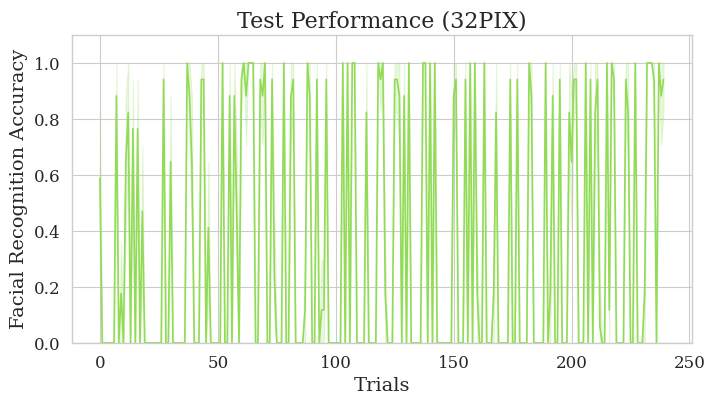

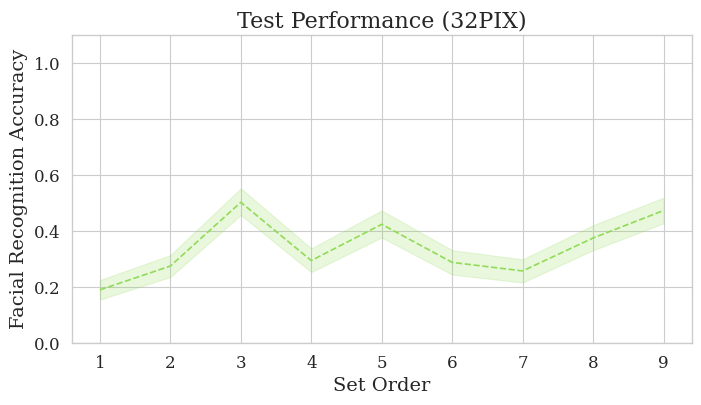

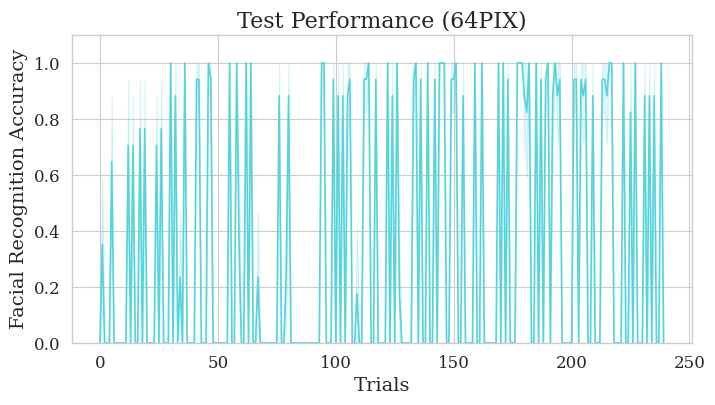

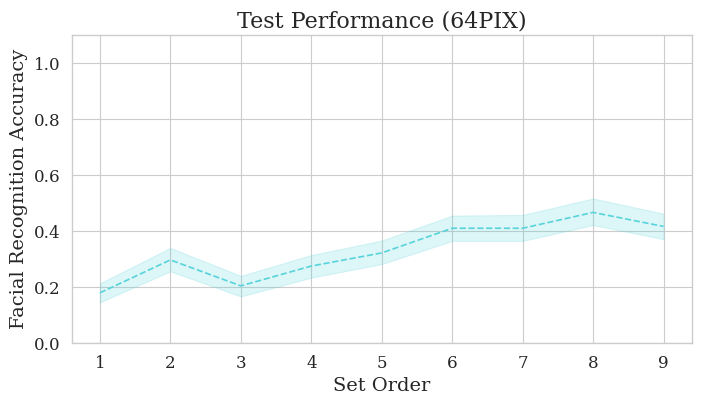

In [130]:
# Draw test performance over trials for each number of pixels
sns.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":14, "xtick.labelsize":12, "ytick.labelsize":12}) 

pix_lst = ['16PIX', '32PIX', '64PIX']
for (i, pix) in enumerate(pix_lst):
    pix_df_temp = hum_mod_df[hum_mod_df['PIX'] == pix].reset_index()

    pix_df = pix_df_temp[sel_mod].stack().reset_index() # sel_ppl or sel_mod
    pix_df.columns = ['Trial', 'Model', 'Mean']

    plt.figure(figsize=(8, 4))
    sns.lineplot(x='Trial', y='Mean', data=pix_df, color=sns.color_palette('hls', len(pix_lst)+1)[i]) 
    plt.ylim([0, 1.1])
    plt.xlabel('Trials')
    plt.ylabel('Facial Recognition Accuracy')
    plt.title(f'Test Performance ({pix})')
    plt.show()

    pix_df_temp.index = pix_df_temp['Set']
    pix_df = pix_df_temp[sel_mod].stack().reset_index() # sel_ppl or sel_mod
    pix_df.columns = ['Set', 'Model', 'Mean']
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='Set', y='Mean', data=pix_df, color=sns.color_palette('hls', len(pix_lst)+1)[i], linestyle='--')
    plt.ylim([0, 1.1])
    plt.xlabel('Set Order')
    plt.ylabel('Facial Recognition Accuracy')
    plt.title(f'Test Performance ({pix})')
    plt.show()

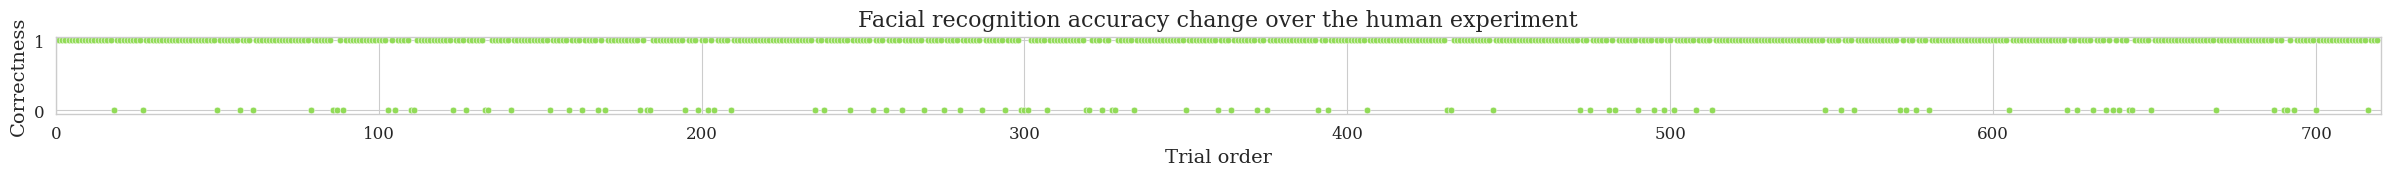

Ratio of 0's:  0.13
Ratio of 1's:  0.87


In [133]:
# Draw accuracy values per set order
plt.figure(figsize=(30, 1))
x = range(processed_human_df_T.shape[0])
sns.scatterplot(x=x, y='Mode', data=processed_human_df_T, color=sns.color_palette('hls', 8)[2])
plt.xlim([0, 720])
plt.xlabel('Trial order')
plt.ylabel('Correctness')
plt.title('Facial recognition accuracy change over the human experiment', y=1.03)
plt.show()

for i in range(2):
    count = pd.Series.value_counts(processed_human_df_T['Mode'])[i]
    tot_count = pd.Series.count(processed_human_df_T['Mode'])
    ratio = count / tot_count
    print(f"Ratio of {i}'s: {ratio : .2f}")

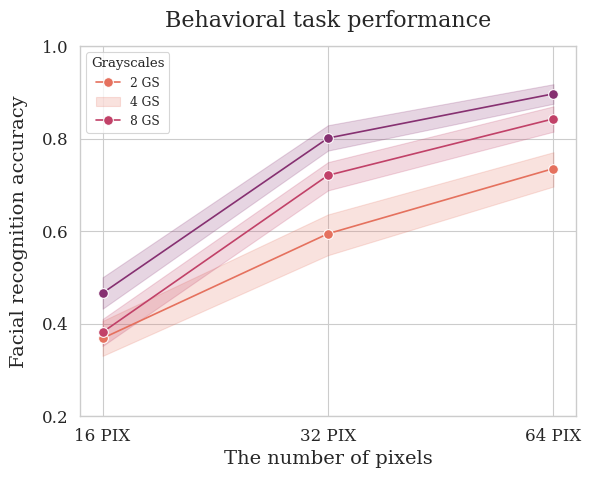

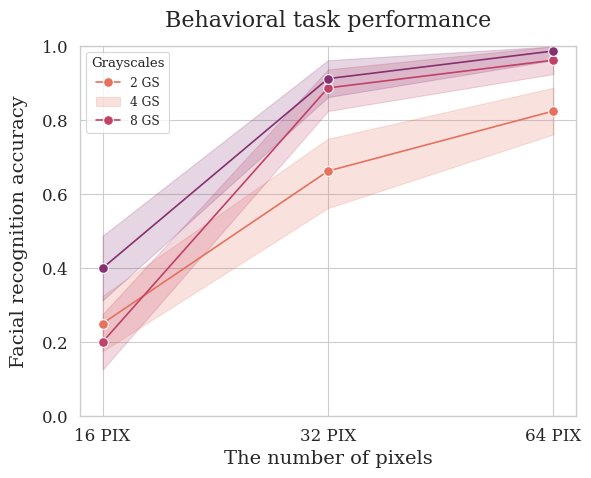

In [7]:
# Draw accuracy plots based on PIX & GS
processed_human_df_T = processed_human_df_T.sort_values(by=['PIX', 'GS'])

sns.lineplot(x='PIX', y='Mean', data=processed_human_df_T, hue='GS', err_style='band', ci=90, palette=sns.color_palette('flare', 3), legend=True, marker='o', markersize=7)
plt.ylim([0.2, 1])
plt.xticks(np.arange(3), labels=['16 PIX', '32 PIX', '64 PIX'])
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('The number of pixels')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='Grayscales', labels=['2 GS', '4 GS', '8 GS'])
plt.show()

sns.lineplot(x='PIX', y='Mode', data=processed_human_df_T, hue='GS', err_style='band', ci=90, palette=sns.color_palette('flare', 3), legend=True, marker='o', markersize=7)
plt.ylim([0, 1])
plt.xticks(np.arange(3), labels=['16 PIX', '32 PIX', '64 PIX'])
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('The number of pixels')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='Grayscales', labels=['2 GS', '4 GS', '8 GS'])
plt.show()


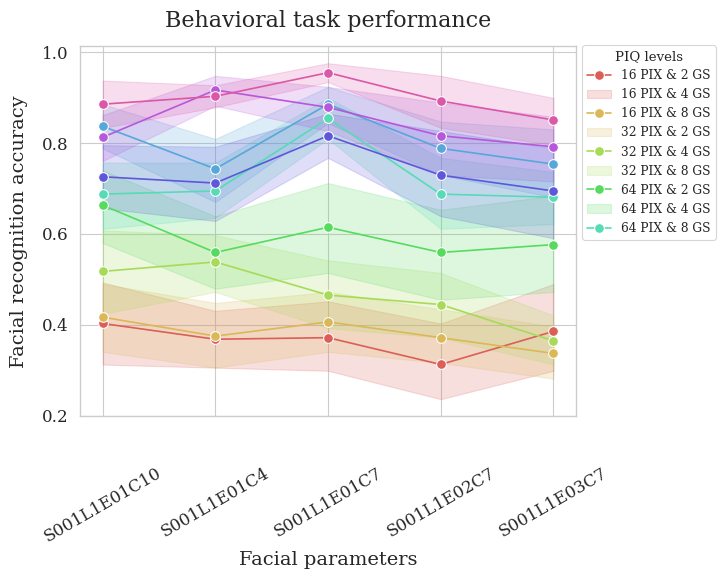

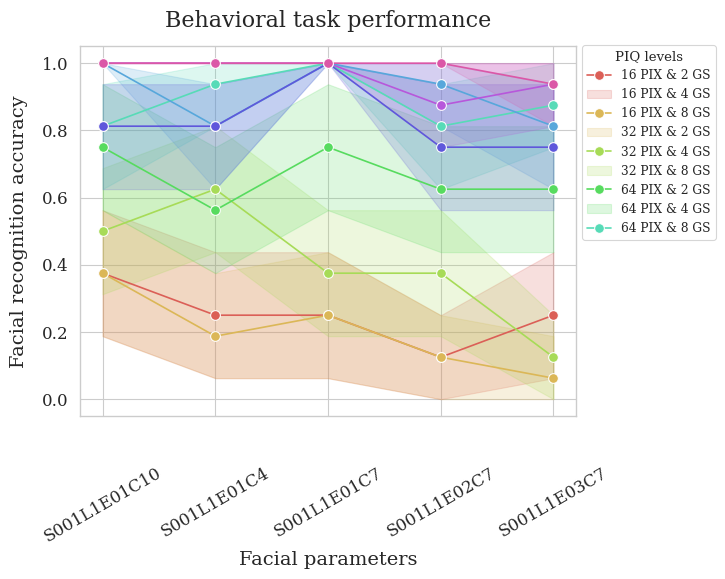

In [24]:
# Draw accuracy plots based on pars
processed_human_df_T = processed_human_df_T.sort_values(by='Par')
hue_order = [('16PIX', '2GS'), ('16PIX', '4GS'), ('16PIX', '8GS'),
             ('32PIX', '2GS'), ('32PIX', '4GS'), ('32PIX', '8GS'),
             ('64PIX', '2GS'), ('64PIX', '4GS'), ('64PIX', '8GS')]

sns.lineplot(x='Par', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('Facial parameters')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

sns.lineplot(x='Par', y='Mode', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('Facial parameters', y=1.5)
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

S001L1E01C10 v.s. S001L1E01C4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.056e+04
S001L1E01C4 v.s. S001L1E01C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.372e+03
S001L1E01C7 v.s. S001L1E02C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.905e-01 U_stat=1.191e+04
S001L1E02C7 v.s. S001L1E03C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.130e+04
S001L1E01C10 v.s. S001L1E01C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.450e+03
S001L1E01C4 v.s. S001L1E02C7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.089e+04
S001L1E01C7 v.s. S001L1E03C7: Mann-Whitney-Wilcoxon test two-sided

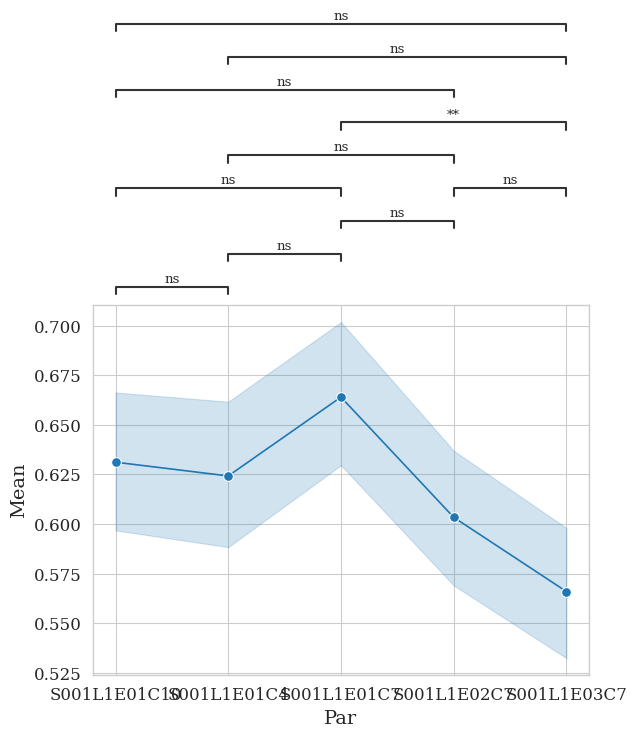

In [144]:
# Check p-values for the averaged pars
box_pairs = [('S001L1E01C10', 'S001L1E01C4'),
             ('S001L1E01C10', 'S001L1E01C7'),
             ('S001L1E01C10', 'S001L1E02C7'),
             ('S001L1E01C10', 'S001L1E03C7'),
             ('S001L1E01C4', 'S001L1E01C7'),
             ('S001L1E01C4', 'S001L1E02C7'),
             ('S001L1E01C4', 'S001L1E03C7'),
             ('S001L1E01C7', 'S001L1E02C7'),
             ('S001L1E01C7', 'S001L1E03C7'),
             ('S001L1E02C7', 'S001L1E03C7')]

plot = sns.lineplot(x='Par', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7)
plot, test_results = add_stat_annotation(plot, data=processed_human_df_T, x='Par', y='Mean',
                                         box_pairs=box_pairs, test='Mann-Whitney', text_format='star', loc='outside', verbose=1)
plt.show()

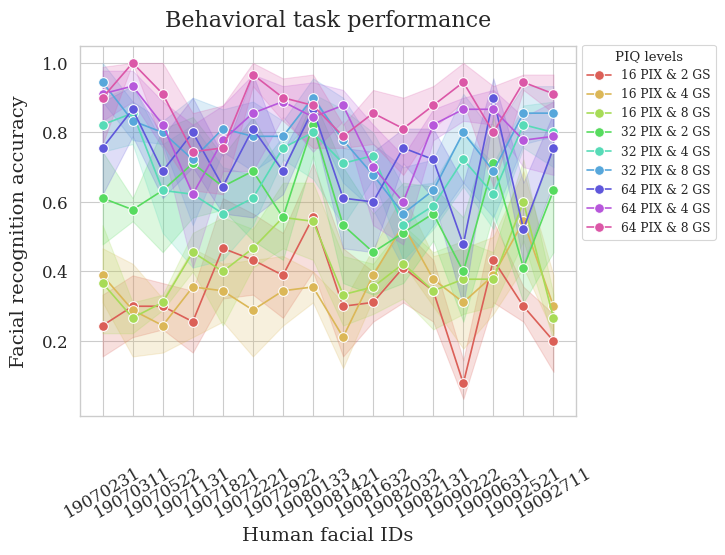

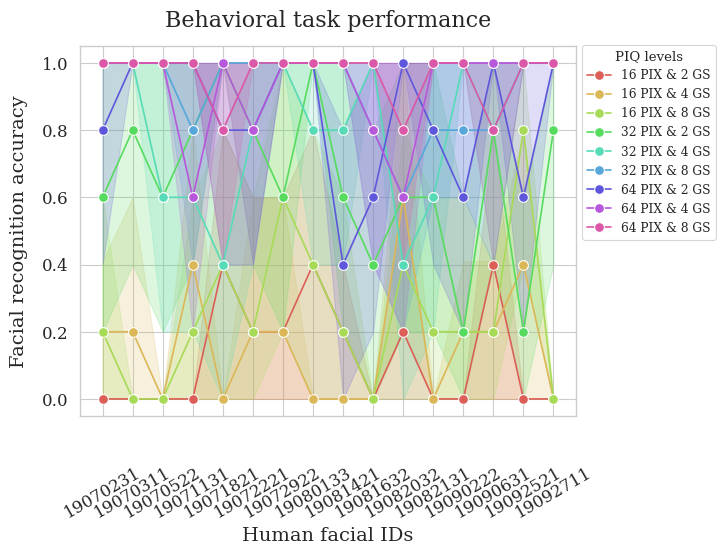

In [145]:
# Draw accuracy plots based on faces
processed_human_df_T = processed_human_df_T.sort_values(by='Face')
hue_order = [('16PIX', '2GS'), ('16PIX', '4GS'), ('16PIX', '8GS'),
             ('32PIX', '2GS'), ('32PIX', '4GS'), ('32PIX', '8GS'),
             ('64PIX', '2GS'), ('64PIX', '4GS'), ('64PIX', '8GS')]

sns.lineplot(x='Face', y='Mean', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.xlabel('Human facial IDs')
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

sns.lineplot(x='Face', y='Mode', data=processed_human_df_T, err_style='band', ci=90, palette=sns.color_palette('hls', 9), marker='o', markersize=7,
             hue=processed_human_df_T[['PIX', 'GS']].apply(tuple, axis=1),
             hue_order=hue_order)
plt.xticks(rotation=30, y=-0.1)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel('Human facial IDs', y=1.5)
plt.ylabel('Facial recognition accuracy', labelpad=10)
plt.title('Behavioral task performance', y=1.03)
plt.legend(title='PIQ levels', bbox_to_anchor=(1, 1.02),
           labels=['16 PIX & 2 GS', '16 PIX & 4 GS', '16 PIX & 8 GS',
                   '32 PIX & 2 GS', '32 PIX & 4 GS', '32 PIX & 8 GS',
                   '64 PIX & 2 GS', '64 PIX & 4 GS', '64 PIX & 8 GS'])
plt.show()

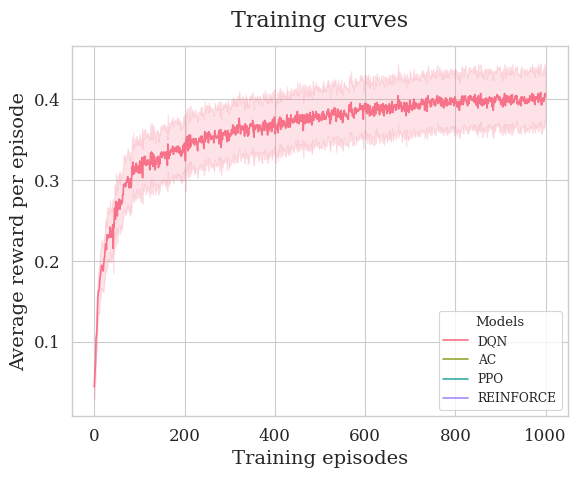

In [35]:
# Check average train returns
train_returns_df = pd.DataFrame()
for (i, file_path) in enumerate(train_returns_files):
    train_returns_df_temp = pd.read_csv(file_path, index_col=0)
    train_returns_df_temp = train_returns_df_temp.transpose().stack().to_frame().reset_index()
    train_returns_df_temp.columns = ['Epochs', 'Timestamps', 'Reward']
    train_returns_df_temp['Models'] = [file_path.split('.')[0].split(f'{slash}')[-1].split('_')[-1]] * train_returns_df_temp.shape[0]
    if i == 0:
        train_returns_df = train_returns_df_temp
    else:
        train_returns_df = pd.concat([train_returns_df, train_returns_df_temp], axis=0)
train_returns_df = train_returns_df.reset_index()
train_returns_df['Epochs'] = train_returns_df['Epochs'].astype(int)

model_order = ['DQN', 'AC', 'PPO', 'REINFORCE']
if env_type == 'CartPole-v1':
    train_returns_df = train_returns_df.groupby(['Epochs', 'Models']).agg('sum').reset_index()

sns.lineplot(x='Epochs', y='Reward', data=train_returns_df, err_style='band', palette='husl', hue='Models', hue_order=model_order)

plt.xticks(range(0, train_returns_df['Epochs'].max() + 2, (train_returns_df['Epochs'].max() + 1) // 5))
plt.xlabel('Training episodes')
plt.ylabel('Average reward per episode')
if env_type == 'CartPole-v1':
    plt.ylim([0, 510])
    plt.legend(loc='lower right')
plt.title('Training curves', y=1.03)
plt.show()

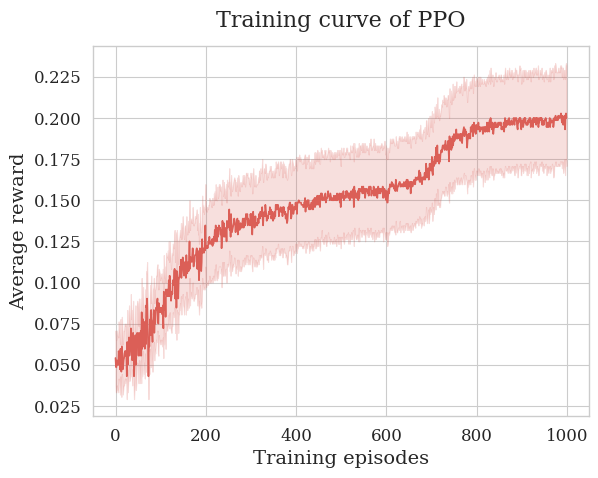

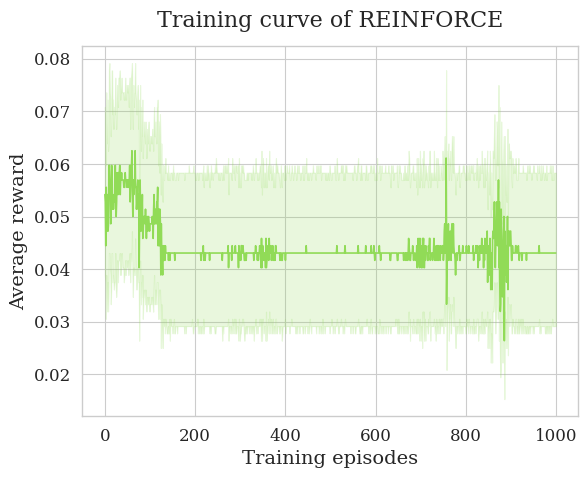

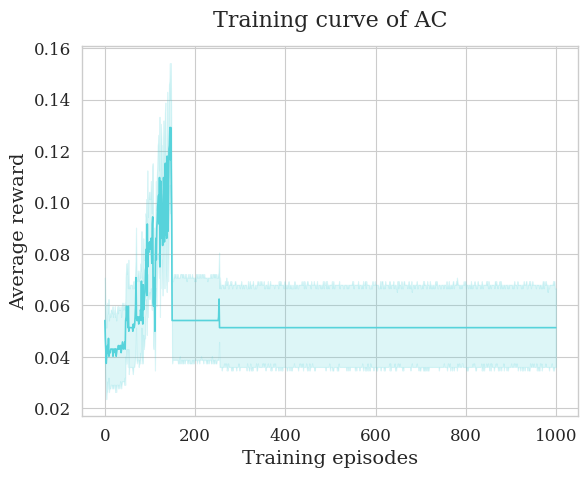

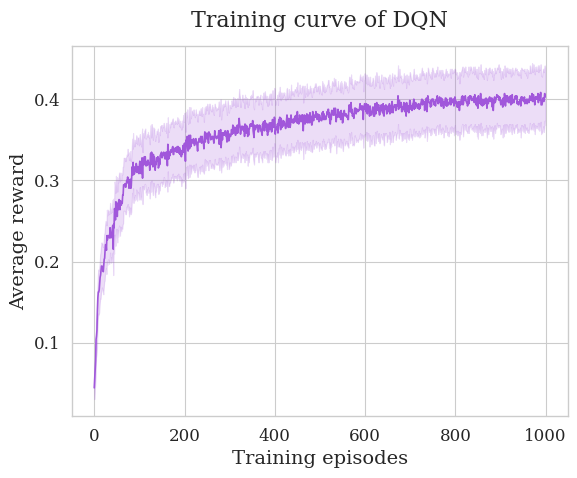

In [47]:
for (i, model_file) in enumerate(model_state_dict_files):
    model_name = model_file.split(f'{slash}')[-1].split('.')[0].split('_')[-1]
    temp_df = train_returns_df[train_returns_df['Models']==model_name]

    sns.lineplot(x='Epochs', y='Reward', data=temp_df, err_style='band', color=sns.color_palette('hls', len(model_state_dict_files))[i])
    plt.xticks(range(0, train_returns_df['Epochs'].max() + 2, (train_returns_df['Epochs'].max() + 1) // 5))
    plt.xlabel('Training episodes')
    plt.ylabel(f'Average reward')
    if env_type == 'CartPole-v1':
        plt.ylim([0, 510])
        plt.legend(loc='lower right')
    plt.title(f'Training curve of {model_name}', y=1.03)
    plt.show()

C:\Users\Na Min An\Desktop\Development\Project\code\outputs\2022-11-07\14-59-04\outputs\Bioniceye_DQN.pth
cnn_num_block.0.weight torch.Size([32, 1, 7, 7])


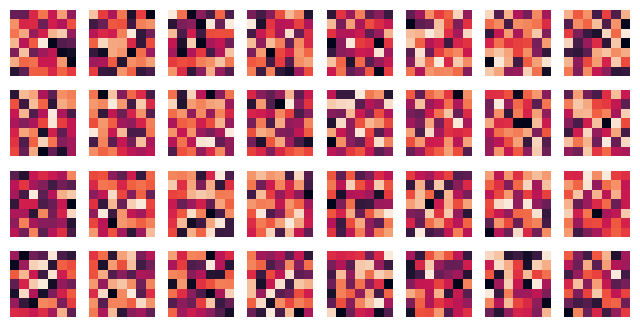

cnn_num_block.0.bias torch.Size([32])
cnn_num_block.3.weight torch.Size([64, 32, 5, 5])


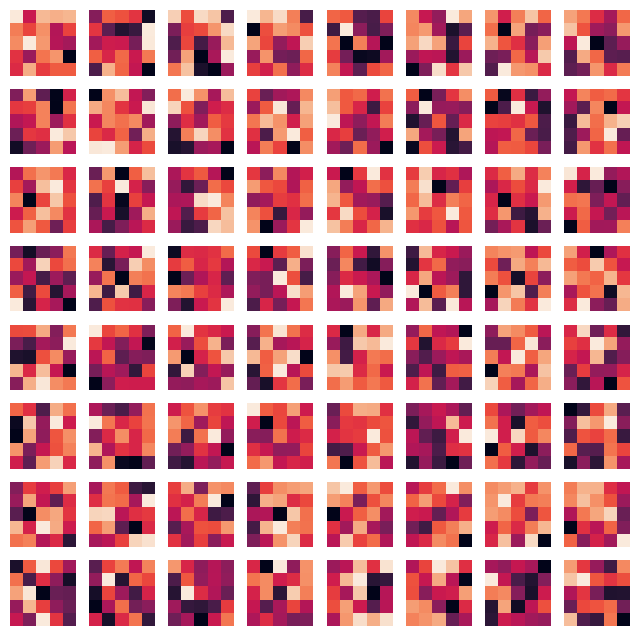

cnn_num_block.3.bias torch.Size([64])
cnn_num_block.6.weight torch.Size([128, 64, 3, 3])


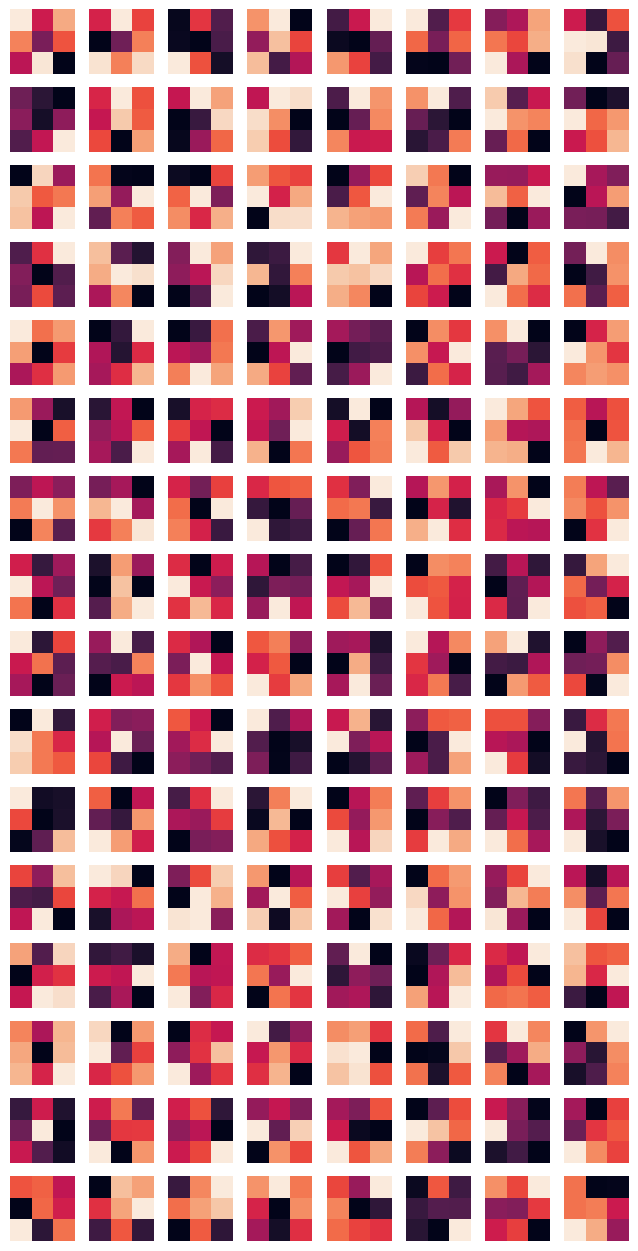

cnn_num_block.6.bias torch.Size([128])
cnn_num_block.9.weight torch.Size([256, 128, 3, 3])


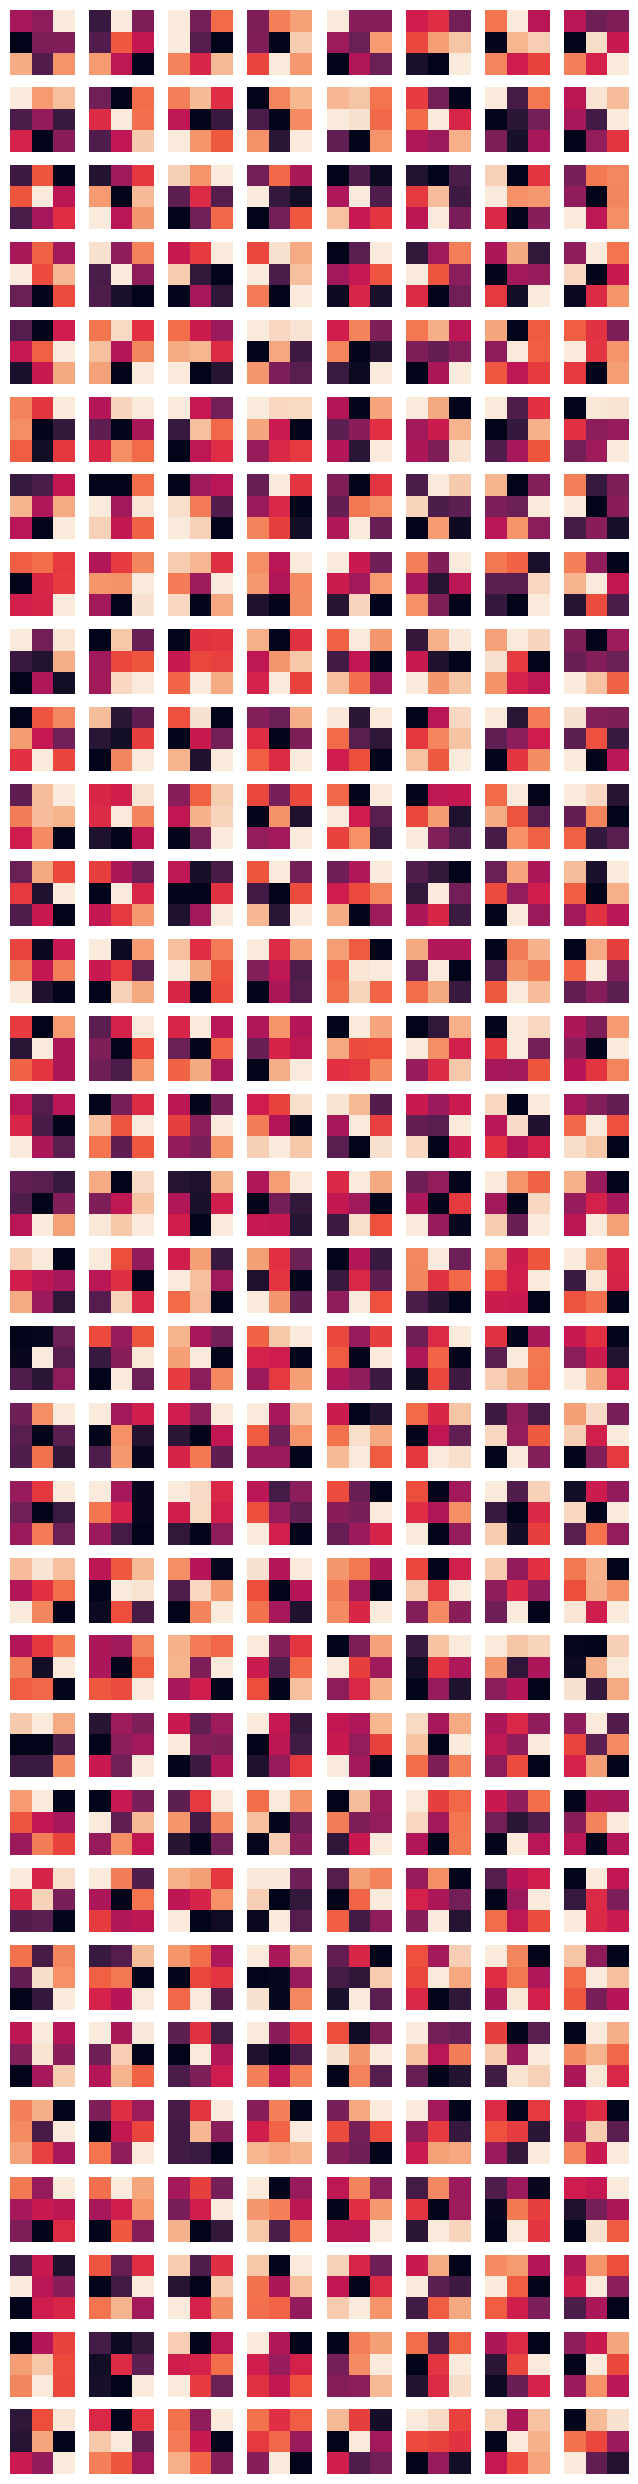

cnn_num_block.9.bias torch.Size([256])
linear_num_block_pi.0.weight torch.Size([128, 30976])


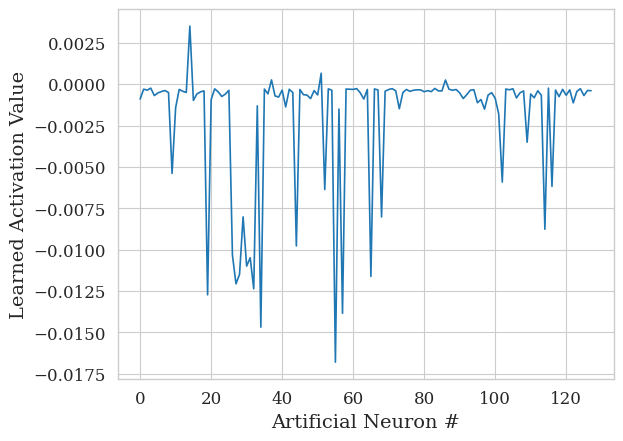

linear_num_block_pi.0.bias torch.Size([128])
linear_num_block_pi.2.weight torch.Size([16, 128])


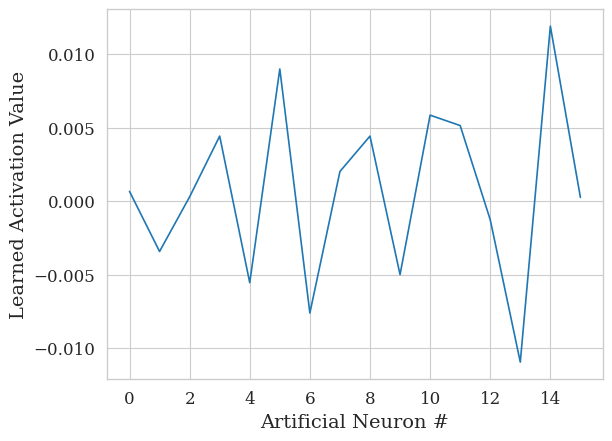

linear_num_block_pi.2.bias torch.Size([16])


In [132]:
# visualize the weights for the best saved model
for file in model_state_dict_files:
    print(file)
    model_dict = torch.load(file)
    for (i, layer_name) in enumerate(model_dict):
        layer_weights = model_dict[layer_name].cpu()
        print(layer_name, layer_weights.shape)

        if layer_name.split('.')[-1] == 'weight':
            if layer_name.split('.')[0] == 'cnn_num_block':
                fig, axes = plt.subplots(layer_weights.shape[0]//8, 8, figsize=(8, layer_weights.shape[0]//8))
                for j in range(layer_weights.shape[0]):
                    axes[j//8, j%8].imshow(layer_weights[j, 0, :, :])
                    axes[j//8, j%8].set_xticklabels([])
                    axes[j//8, j%8].set_yticklabels([])
                    axes[j//8, j%8].axis('off')
            elif layer_name.split('.')[0] == 'linear_num_block_pi':
                layer_weights = layer_weights.mean(axis=-1)
                plt.plot(layer_weights)
                plt.xlabel('Artificial Neuron #')
                plt.ylabel('Learned Activation Value')
            plt.show()